# Approximation Methods
We want to approximate V(s) and Q(s,a). We can use neural networks, because they are universal function approximators.<br>
First, we extract features X from the states S, and then we find a function f(x, theta) that approximates V(s). We do the feature extraction in order to use linear models, because for deep NNs is not required.<br>

# Feature Engineering
We can treat the states as a categorical variable, so we can use One Hot Encoding. The problem is that we are not compressing the representation. <br>
We can use x = (x1, x2) to represent s = (i, j) and then normalize it.<br>
A linear model is not expressive enough t represent our V(s), so we can use higher grade polynomials like x1^2, x2^2, x1*x2.

# Monte Carlo Approximation
We will approximate the V(s) with a linear model, updating the parameters theta using Stochastic Gradient Descent.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from grid_world import negative_grid, standard_grid
plt.rcParams['figure.figsize'] = (15,7)

In [2]:
THRESHOLD = 10e-4
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def print_values(V, g):
    for i in range(g.width):
        print('-----------------------')
        for j in range(g.height):
            v = V.get((i, j), 0)
            if v >= 0:
                print(' {0:.2f}'.format(v), end = ' ')
            else:
                print('{0:.2f}'.format(v), end = ' ')
        print()
    print('-----------------------')

def print_policy(P, g):
    for i in range(g.width):
        print('---------------')
        for j in range(g.height):
            p = P.get((i, j), ' ')
            print(' ' + p + ' ', end = ' ')
        print()
    print('---------------')

In [4]:
def play_game(grid, policy):
    ## Exploring start method
    start_states = list(grid.actions.keys())
    start = start_states[np.random.choice(len(start_states))]
    grid.set_state(start)
    states_and_rewards = [(start, 0)]
    s = start
    while not grid.game_over():
        a = policy[s]
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s, r))
    
    G = 0
    states_and_returns = []
    first = True
    for s, r in states_and_rewards[::-1]:
        if not first:
            states_and_returns.append((s, G))
        else:
            first = False
        G = r + GAMMA * G
    return states_and_returns

Rewards:
-----------------------
 0.00  0.00  0.00  1.00 
-----------------------
 0.00  0.00  0.00 -1.00 
-----------------------
 0.00  0.00  0.00  0.00 
-----------------------
Policy:
---------------
 R   R   R      
---------------
 U       U      
---------------
 U   L   U   L  
---------------



100%|██████████████████████████████████| 10000/10000 [00:01<00:00, 6265.46it/s]


Value:
-----------------------
 0.76  0.89  1.02  0.00 
-----------------------
 0.73  0.00  0.87  0.00 
-----------------------
 0.70  0.71  0.73  0.74 
-----------------------


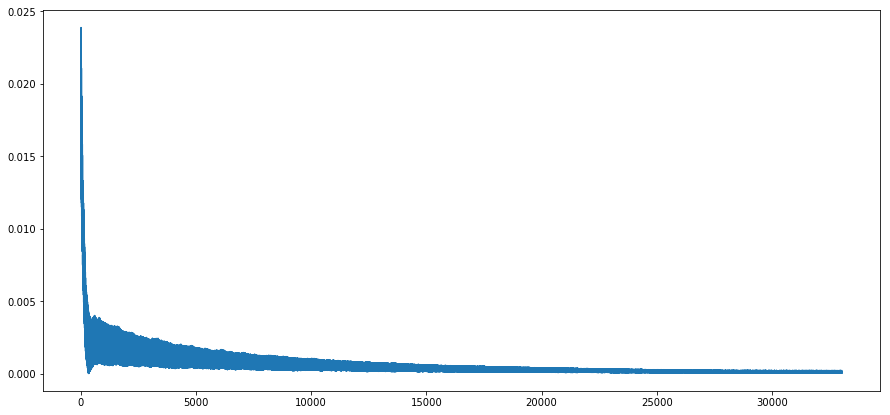

In [23]:
LEARNING_RATE = 0.001

def transform(s):
    return np.array([1, s[0] - 1, s[1] - 1.5, s[0] * s[1] - 3])

def v(s, theta):
    s = transform(s)
    return np.dot(s, theta)

grid = standard_grid()

print('Rewards:')
print_values(grid.rewards, grid)

states = grid.all_states()
#V = {s: 0 for s in states}
#returns = {s: [] for s in states}
theta = np.random.rand(4)
policy = {(2,0): 'U',
         (1,0): 'U',
         (0,0): 'R',
         (0,1): 'R',
         (0,2): 'R',
         (1,2): 'U',
         (2,1): 'L',
         (2,2): 'U',
         (2,3): 'L'}
print('Policy:')
print_policy(policy, grid)
grid.policy = policy
print()

t = 1
deltas = []
for i in tqdm.tqdm(range(10000)):
    if i % 100 == 0:
        t += 0.01
    biggest_change = 0
    alpha = LEARNING_RATE / t
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, g in states_and_returns:
        if not s in seen_states:
            old_theta = theta.copy()
            theta += alpha * (g - v(s, theta)) * transform(s)
            biggest_change = max(biggest_change, np.abs(old_theta - theta).sum())
        deltas.append(biggest_change)
        seen_states.add(s)

V = {s: v(s, theta) if s in grid.actions else 0 for s in states}
print('Value:')
print_values(V, grid)

plt.plot(deltas)
plt.show()

# TD(0) Prediction Approximation
In TD(0) we don't have the expected return G like in MC, instead we use $r + \gamma V(s)$ to estimate it. So the update equation becomes:

$$ \theta = \theta + \alpha (r + \gamma \hat{V}(s', \theta) - \hat{V}(s, \theta))\frac{\partial \hat{V}(s, \theta)}{\partial \theta} $$

Rewards:
-----------------------
 0.00  0.00  0.00  1.00 
-----------------------
 0.00  0.00  0.00 -1.00 
-----------------------
 0.00  0.00  0.00  0.00 
-----------------------
Random policy:
---------------
 R   R   R      
---------------
 U       R      
---------------
 U   R   R   U  
---------------



100%|██████████████████████████████████| 20000/20000 [00:05<00:00, 3845.54it/s]


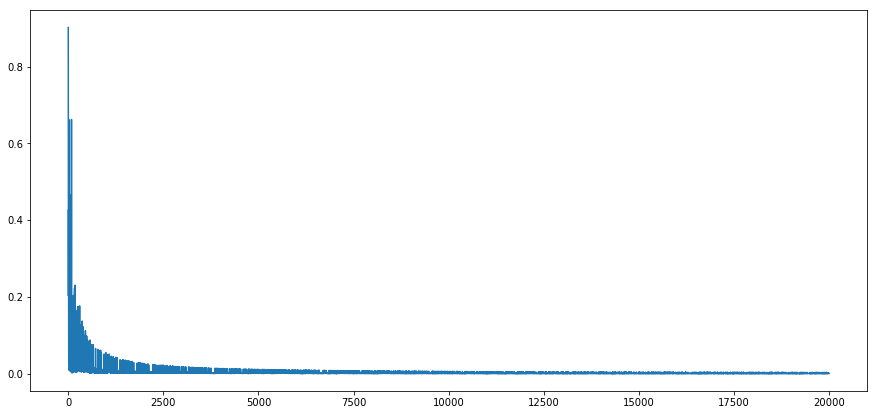

Policy
---------------
 R   R   R      
---------------
 U       R      
---------------
 U   R   R   U  
---------------

Value function:
-----------------------
 0.77  0.86  0.95  0.00 
-----------------------
 0.67  0.00 -0.04  0.00 
-----------------------
 0.57 -0.23 -1.04 -1.84 
-----------------------


In [33]:
def random_action(a, eps=0.1):
    p = np.random.rand()
    if p < 1 - eps:
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

def play_game_TD(grid, policy):
    s = (2, 0)
    grid.set_state(s)
    states_and_rewards = [(s, 0)]
    while not grid.game_over():
        r = grid.move(random_action(policy[s]))
        s = grid.current_state()
        states_and_rewards.append((s, r))
    return states_and_rewards

LEARNING_RATE = 0.001

def transform(s):
    return np.array([1, s[0] - 1, s[1] - 1.5, s[0] * s[1] - 3])

def v(s, theta):
    s = transform(s)
    return np.dot(s, theta)

grid = standard_grid()
print('Rewards:')
print_values(grid.rewards, grid)

states = grid.all_states()
theta = np.random.rand(4)
policy = {(2,0): 'U',
         (1,0): 'U',
         (0,0): 'R',
         (0,1): 'R',
         (0,2): 'R',
         (1,2): 'R',
         (2,1): 'R',
         (2,2): 'R',
         (2,3): 'U'}
print('Random policy:')
print_policy(policy, grid)
grid.policy = policy
print()

t = 0
deltas = []
for i in tqdm.tqdm(range(20000)):
    if i % 100 == 0:
        t += 0.01
    biggest_change = 0
    alpha = LEARNING_RATE / t
    # policy evaluation
    states_and_rewards = play_game_TD(grid, policy)
    for j in range(len(states_and_rewards) - 1):
        old_theta = theta.copy()
        s, _ = states_and_rewards[j]
        s2, r = states_and_rewards[j + 1]
        if grid.is_terminal(s2):
            target = r
        else:
            target = r + GAMMA * v(s2, theta)
        theta += alpha * (target - v(s, theta)) * transform(s)
        biggest_change = max(biggest_change, np.abs(old_theta - theta).sum())
    deltas.append(biggest_change)
    
plt.plot(deltas)
plt.show()

print('Policy')
print_policy(policy, grid)
    
V = {s: v(s, theta) if s in grid.actions else 0 for s in states}
print('\nValue function:')
print_values(V, grid)

# SARSA Approximation - Control problem
We are going to approximate Q(s, a), so we have to approximate |S|x|A| values instead of |S|. The idea is the same:

$$ \theta = \theta + \alpha (r + \gamma \hat{Q}(s', a', \theta) - \hat{Q}(s, a, \theta))\frac{\partial \hat{Q}(s, a, \theta)}{\partial \theta} $$

